In [1]:
!pip install shap scikit-learn pandas -q

In [2]:
#  Import Libraries
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import shap
import datetime

In [7]:
# #  Load Dataset and Add Sensitive Attribute
# credit_data = fetch_openml(name='credit-g', version=1, as_frame=True)

# # Features (X) and Target (y)
# X = credit_data.data
# y = credit_data.target.map({'good': 1, 'bad': 0})

# print("Dataset shape:", X.shape)
# print("Target distribution:\n", y.value_counts())

# # Add synthetic sensitive attribute - Age Group (0: Younger, 1: Older)
# np.random.seed(42)
# X['age_group'] = np.random.choice([0, 1], size=len(y), p=[0.6, 0.4])

#  Load Dataset and Add Sensitive Attribute (with categorical encoding)
credit_data = fetch_openml(name='credit-g', version=1, as_frame=True)

# Features (X) and Target (y)
X = credit_data.data
y = credit_data.target.map({'good': 1, 'bad': 0})

print("Dataset shape:", X.shape)
print("Target distribution:\n", y.value_counts())

# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)

# Add synthetic sensitive attribute - Age Group (0: Younger, 1: Older)
np.random.seed(42)
X['age_group'] = np.random.choice([0, 1], size=len(y), p=[0.6, 0.4])


Dataset shape: (1000, 20)
Target distribution:
 class
1    700
0    300
Name: count, dtype: int64


In [8]:
#  Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


In [9]:
# Train Model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [10]:
# Task: Evaluate Model
y_pred = clf.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.36      0.47        91
           1       0.77      0.93      0.84       209

    accuracy                           0.76       300
   macro avg       0.73      0.65      0.66       300
weighted avg       0.74      0.76      0.73       300



In [11]:
# Task: Log Model Performance
audit_log = {
    "timestamp": datetime.datetime.now().isoformat(),
    "classification_report": classification_report(y_test, y_pred, output_dict=True),
    "confusion_matrix": confusion_matrix(y_test, y_pred).tolist()
}
print("\nAudit Log Initial Entry:\n", audit_log)



Audit Log Initial Entry:
 {'timestamp': '2025-08-14T08:08:20.573075', 'classification_report': {'0': {'precision': 0.6875, 'recall': 0.3626373626373626, 'f1-score': 0.4748201438848921, 'support': 91.0}, '1': {'precision': 0.7698412698412699, 'recall': 0.9282296650717703, 'f1-score': 0.841648590021692, 'support': 209.0}, 'accuracy': 0.7566666666666667, 'macro avg': {'precision': 0.7286706349206349, 'recall': 0.6454335138545665, 'f1-score': 0.6582343669532921, 'support': 300.0}, 'weighted avg': {'precision': 0.7448644179894179, 'recall': 0.7566666666666667, 'f1-score': 0.7303772946935294, 'support': 300.0}}, 'confusion_matrix': [[33, 58], [15, 194]]}


In [13]:
# Task: Detect Bias by Age Group
test_results = X_test.copy()

# Ensure numeric types for aggregation
test_results['actual'] = pd.to_numeric(y_test)
test_results['predicted'] = pd.to_numeric(y_pred)

grouped = test_results.groupby('age_group').agg(
    total=('actual', 'count'),
    positive_rate_actual=('actual', 'mean'),
    positive_rate_predicted=('predicted', 'mean')
)

print("\nOutcome rates by Age Group:\n", grouped)

# Add bias report to audit log
bias_report = grouped.to_string()
audit_log['bias_report'] = bias_report



Outcome rates by Age Group:
            total  positive_rate_actual  positive_rate_predicted
age_group                                                      
0            188              0.686170                 0.835106
1            112              0.714286                 0.848214


/tmp/ipython-input-2582972326.py:21: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:,:,1], X_test_enc)


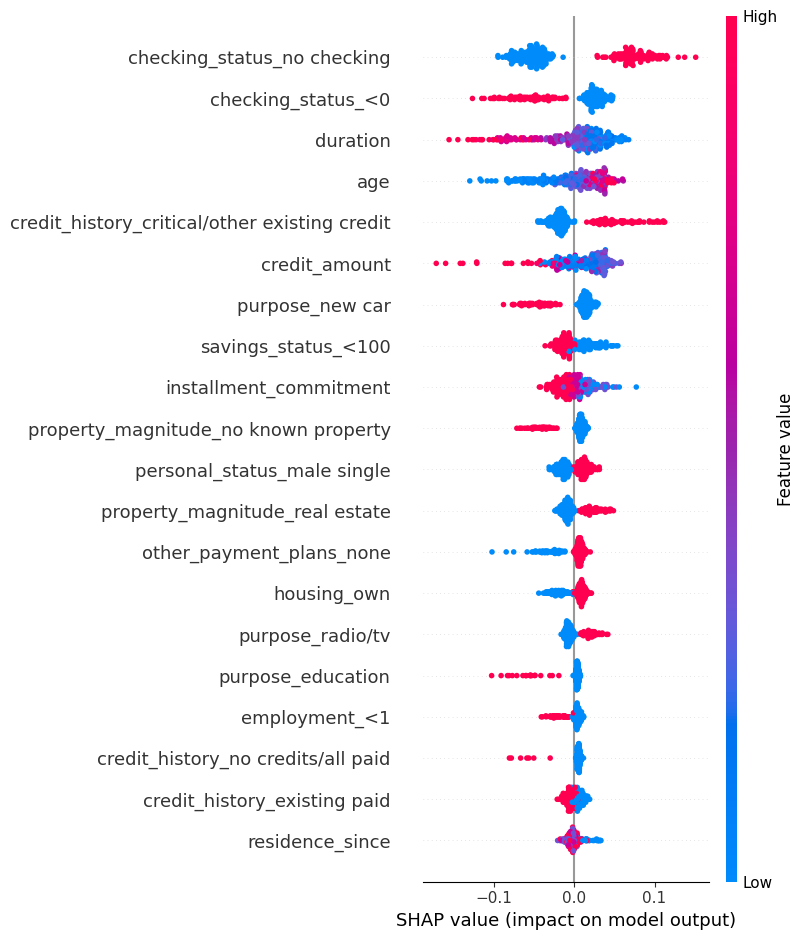

In [18]:
# Task: Interpret Model with SHAP

# Encode categorical features before training
X_encoded = pd.get_dummies(X, drop_first=True)

# Train/test split on encoded data
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(
    X_encoded, y, test_size=0.3, random_state=42
)

# Train model
clf_enc = RandomForestClassifier(random_state=42)
clf_enc.fit(X_train_enc, y_train_enc)

# Create SHAP explainer
explainer = shap.TreeExplainer(clf_enc)
shap_values = explainer.shap_values(X_test_enc)

# For binary classification, shap_values is a list: [array_for_class0, array_for_class1]
# Plot summary for the positive class (index 1)
shap.summary_plot(shap_values[:,:,1], X_test_enc)



In [19]:
# Task: Generate Compliance and Audit Report
compliance_notes = f"""
Model Compliance and Audit Report:
-----------------------------------
Timestamp: {audit_log['timestamp']}

Bias Detection:
Outcome disparities between age groups:
{bias_report}

Model Performance:
- Detailed metrics in classification report
- Confusion matrix: {audit_log["confusion_matrix"]}

Transparency:
- SHAP used to interpret feature importance and influence
- Explainability provided for decision accountability

Governance & Auditing:
- Metrics, bias analysis, and interpretability documented
- Ready for review under AI governance and financial regulatory frameworks
"""

print(compliance_notes)



Model Compliance and Audit Report:
-----------------------------------
Timestamp: 2025-08-14T08:08:20.573075

Bias Detection:
Outcome disparities between age groups:
           total  positive_rate_actual  positive_rate_predicted
age_group                                                      
0            188              0.686170                 0.835106
1            112              0.714286                 0.848214

Model Performance:
- Detailed metrics in classification report
- Confusion matrix: [[33, 58], [15, 194]]

Transparency:
- SHAP used to interpret feature importance and influence
- Explainability provided for decision accountability

Governance & Auditing:
- Metrics, bias analysis, and interpretability documented
- Ready for review under AI governance and financial regulatory frameworks

